In [49]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import os
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

Location Cordinates



In [50]:
# === Location coordinates (optional) ===
LOCATION_COORDINATES = {
    "BKC": (19.0688, 72.8703),
    "BandraMPCB": (19.0418, 72.8653),
    "BoriValiEastIITM": (19.228825, 72.854118),
    "BoriValiEastMPCB": (19.2298, 72.8609),
    "AndheriEast": (19.1179, 72.8631),
    "VileParleWestMumbai": (19.1071, 72.8368),
    "VasaiWestMumbai": (19.366636, 72.816101),
    "SionMumbai": (19.0390, 72.8619),
    "Worli": (18.9986, 72.8174),
    "SiddharthNagarWorli": (18.9978, 72.8139),
    "PowaiMumbai": (19.1176, 72.9060),
    "NavyNagarColaba": (18.8980, 72.8131),
    "MulundWestMumbai": (19.1759, 72.9521),
    "MazgaonMumbai": (18.9596, 72.8459),
    "MaladWestMumbai": (19.1890, 72.8355),
    "KurlaMumbai": (19.0726, 72.8845),
    "KhindipadaBhandupWestMumbai": (19.1599, 72.9239),
    "KandivaliEastMumbai": (19.2005, 72.8737),
    "DeonarMumbai": (19.0447, 72.9103),
    "ColabaMumbai": (18.9067, 72.8147),
    "ChhatrapatiShivajiIntlAirport": (19.0902, 72.8628),
    "ChakalaAndheri": (19.1098, 72.8583)
}

In [51]:
files = {
        "BKC": "BandraKurlaComplexMumbaiIITM.csv",
        "BandraMPCB": "BandraMumbaiMPCB.csv",
        "BoriValiEastIITM": "BorivaliEastMumbaiIITM.csv",
        "BoriValiEastMPCB": "BorivaliEastMumbaiMPCB.csv",
        "AndheriEast": "ChakalaAndheriEastMumbaiIITM.csv",
        "VileParleWestMumbai": "VileParleWestMumbaiMPCB.csv",
        "VasaiWestMumbai": "VasaiWestMumbaiMPCB.csv",
        "SionMumbai": "SionMumbaiMPCB.csv",
        "SiddharthNagarWorli": "SiddharthNagarWorliMumbaiIITM.csv",
        "PowaiMumbai": "PowaiMumbaiMPCB.csv",
        "NavyNagarColaba": "NavyNagarColabaMumbaiIITM.csv",
        "MulundWestMumbai": "MulundWestMumbaiMPCB.csv",
        "MazgaonMumbai": "MazgaonMumbaiIITM.csv",
        "MaladWestMumbai": "MaladWestMumbaiIITM.csv",
        "KurlaMumbai": "KurlaMumbaiMPCB.csv",
        "KhindipadaBhandupWestMumbai": "KhindipadaBhandupWestMumbaiIITM.csv",
        "KandivaliEastMumbai": "KandivaliEastMumbaiMPCB.csv",
        "DeonarMumbai": "DeonarMumbaiIITM.csv",
        "ColabaMumbai": "ColabaMumbaiMPCB.csv",
        "ChhatrapatiShivajiIntlAirport": "ChhatrapatiShivajiIntlAirportT2MumbaiMPCB.csv",
        "ChakalaAndheri": "ChakalaAndheriEastMumbaiIITM.csv",
        "Worli": "WorliMumbaiMPCB.csv"
    }


AQI Breakpoint calcultion Formulae


In [52]:
# === CPCB AQI Breakpoint Formula ===
def calculate_cpcb_aqi(pollutant, concentration):
    breakpoints = {
        "pm25": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200), (91, 120, 201, 300),
                 (121, 250, 301, 400), (251, 500, 401, 500)],
        "pm10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200), (251, 350, 201, 300),
                 (351, 430, 301, 400), (431, 500, 401, 500)],
        "no2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200), (181, 280, 201, 300),
                (281, 400, 301, 400), (401, 500, 401, 500)],
        "o3": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200), (169, 208, 201, 300),
               (209, 748, 301, 400), (749, 1000, 401, 500)],
    }

    for bp in breakpoints.get(pollutant, []):
        Clow, Chigh, Ilow, Ihigh = bp
        if Clow <= concentration <= Chigh:
            return round(((Ihigh - Ilow) / (Chigh - Clow)) * (concentration - Clow) + Ilow)
    return None

Loading and Processing the Data

In [53]:
# === Load and preprocess data ===
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    df = df.rename(columns={"from_date": "timestamp", "ozone": "o3", "pm2.5": "pm25"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')
    df = df[["timestamp", "pm25", "pm10", "no2", "o3"]].dropna()
    df = df.set_index("timestamp").resample("h").mean().dropna()

    def rowwise_aqi(row):
        return max(filter(None, [
            calculate_cpcb_aqi("pm25", row["pm25"]),
            calculate_cpcb_aqi("pm10", row["pm10"]),
            calculate_cpcb_aqi("no2", row["no2"]),
            calculate_cpcb_aqi("o3", row["o3"]),
        ]), default=None)

    df["calculated_aqi"] = df.apply(rowwise_aqi, axis=1)
    return df

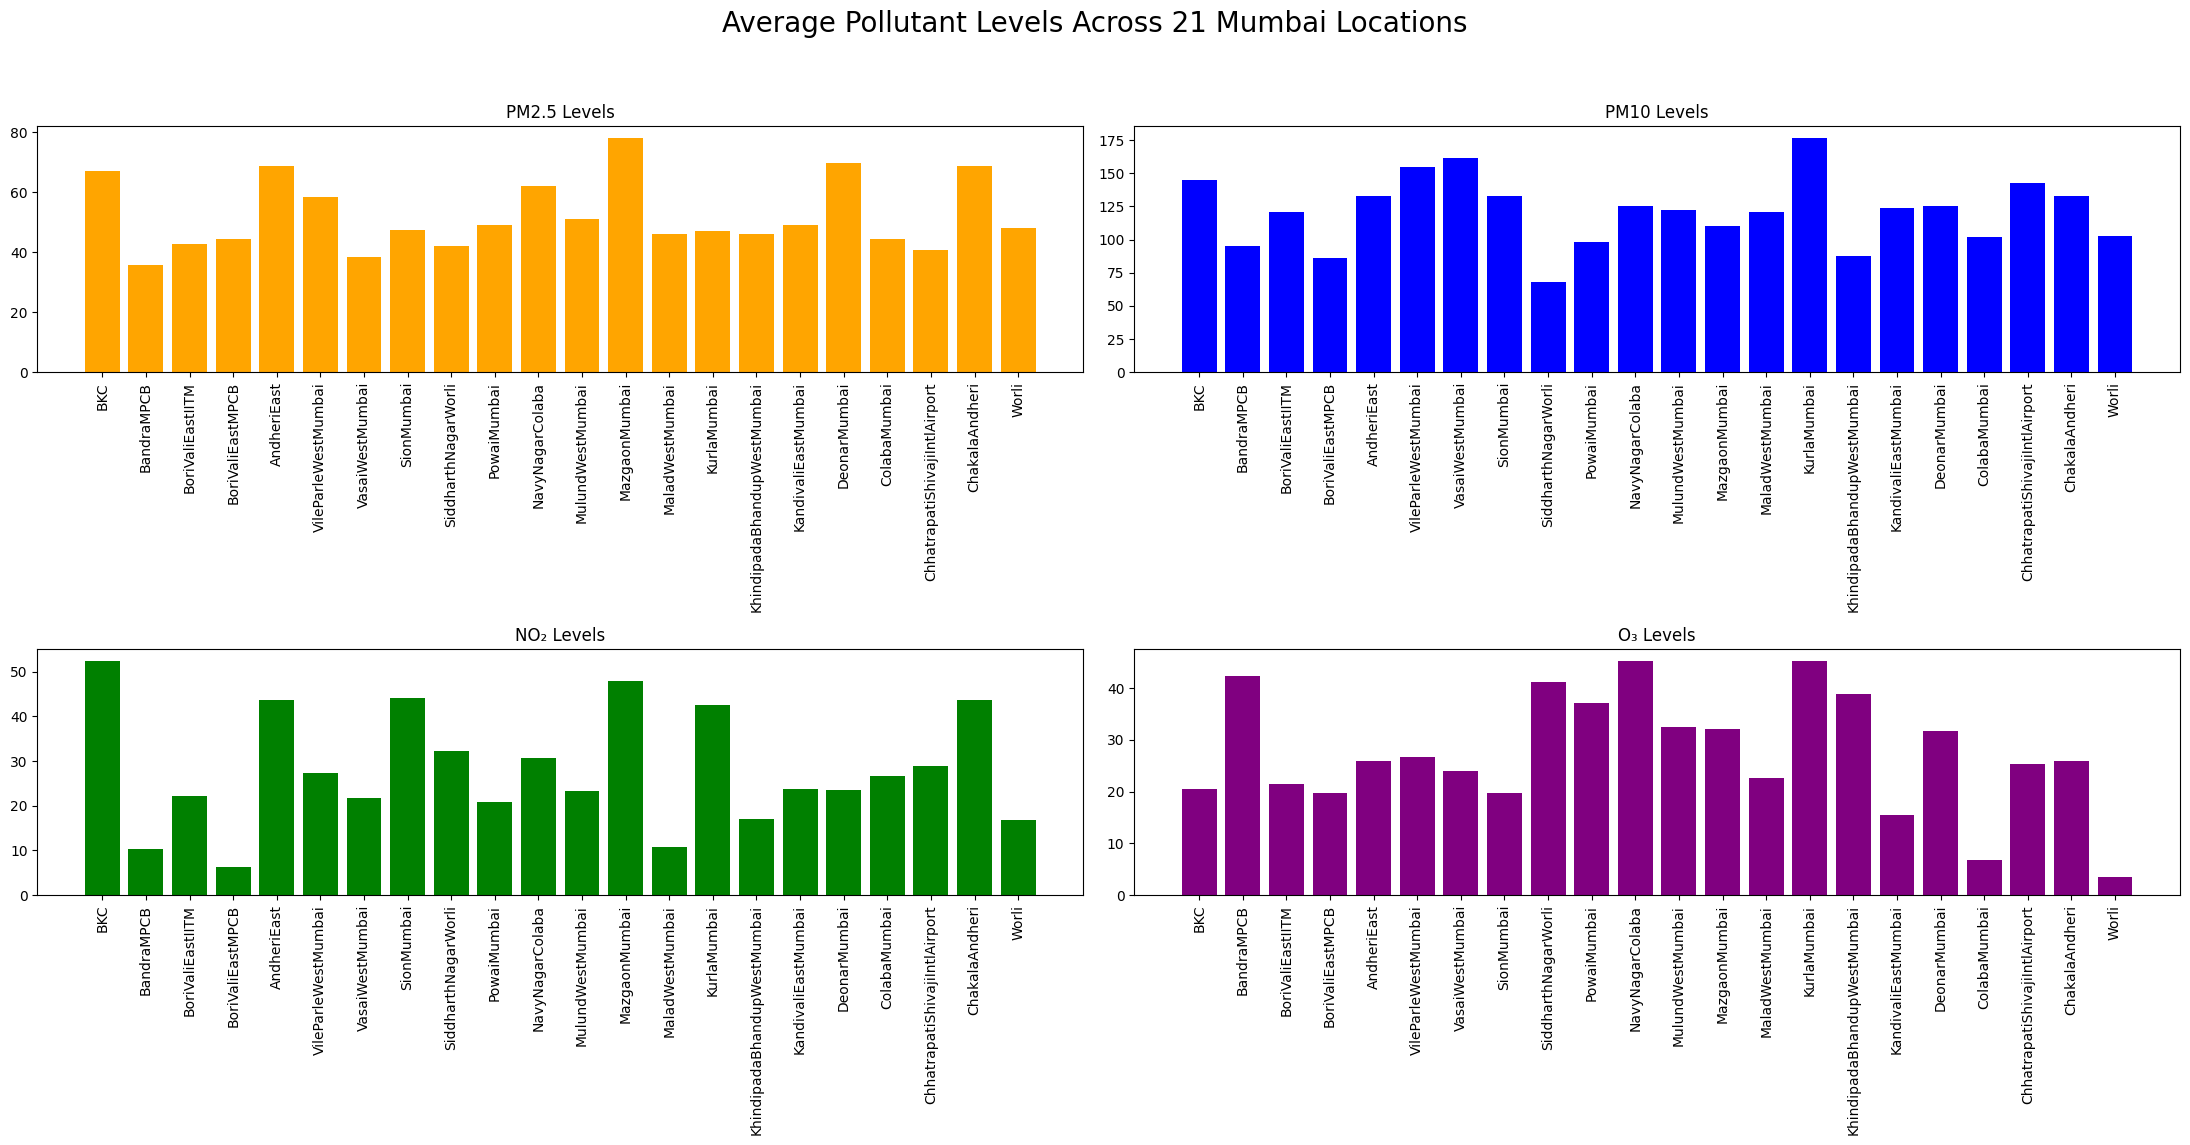

In [54]:
# Step 3: Initialize Pollutant Data Storage
pollutant_data = {
    "Location": [],
    "PM2.5": [],
    "PM10": [],
    "NO2": [],
    "O3": []
}

# Step 4: Process Each File and Extract Averages
for location, filename in files.items():
    try:
        df = pd.read_csv(filename)
        df.columns = df.columns.str.strip().str.upper().str.replace(" ", "_")

        pollutant_data["Location"].append(location)
        pollutant_data["PM2.5"].append(pd.to_numeric(df.get("PM2.5", pd.Series([None])), errors='coerce').mean())
        pollutant_data["PM10"].append(pd.to_numeric(df.get("PM10", pd.Series([None])), errors='coerce').mean())
        pollutant_data["NO2"].append(pd.to_numeric(df.get("NO2", pd.Series([None])), errors='coerce').mean())
        pollutant_data["O3"].append(pd.to_numeric(df.get("OZONE", pd.Series([None])), errors='coerce').mean())

    except Exception as e:
        print(f"⚠️ Error processing {filename}: {e}")

# Step 5: Convert to DataFrame
pollutants_df = pd.DataFrame(pollutant_data)

# Step 6: Plot the Graphs
fig, axs = plt.subplots(2, 2, figsize=(22, 12))
fig.suptitle("Average Pollutant Levels Across 21 Mumbai Locations", fontsize=20)

axs[0, 0].bar(pollutants_df["Location"], pollutants_df["PM2.5"], color='orange')
axs[0, 0].set_title("PM2.5 Levels")
axs[0, 0].tick_params(axis='x', rotation=90)

axs[0, 1].bar(pollutants_df["Location"], pollutants_df["PM10"], color='blue')
axs[0, 1].set_title("PM10 Levels")
axs[0, 1].tick_params(axis='x', rotation=90)

axs[1, 0].bar(pollutants_df["Location"], pollutants_df["NO2"], color='green')
axs[1, 0].set_title("NO₂ Levels")
axs[1, 0].tick_params(axis='x', rotation=90)

axs[1, 1].bar(pollutants_df["Location"], pollutants_df["O3"], color='purple')
axs[1, 1].set_title("O₃ Levels")
axs[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Feature Engineering


In [55]:
# === Feature Engineering ===
def add_features(df):
    for col in ["pm25", "pm10", "no2", "o3"]:
        df[f"{col}_roll3"] = df[col].rolling(3).mean()
        df[f"{col}_roll7"] = df[col].rolling(7).mean()
        df[f"{col}_std3"] = df[col].rolling(3).std()
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    df["day"] = df.index.day
    return df.dropna()

XGBoost Model


In [56]:
def train_aqi_model(df, flag):
    features = [col for col in df.columns if col != "calculated_aqi"]
    X = df[features]
    y = df["calculated_aqi"]
    split = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]

    model = XGBRegressor(objective='reg:squarederror', n_estimators=200, max_depth=4, learning_rate=0.1)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    if flag!=1:
      print("\n📈 AQI Model Accuracy:")
      print(f"  MAE : {mean_absolute_error(y_test, preds):.2f}")
      print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}")
      print(f"  R²  : {r2_score(y_test, preds):.2f}")
    return model, y_test, preds


In [58]:
for location, path in files.items():
        if not os.path.exists(path):
            print(f"⚠️ File not found: {path}")
            continue

        print(f"\n=== Processing {location} ===")
        df = load_and_clean_data(path)
        df = add_features(df)

        model, y_test, preds = train_aqi_model(df,0)


=== Processing BKC ===

📈 AQI Model Accuracy:
  MAE : 12.59
  RMSE: 23.10
  R²  : 0.95

=== Processing BandraMPCB ===

📈 AQI Model Accuracy:
  MAE : 3.37
  RMSE: 8.92
  R²  : 0.96

=== Processing BoriValiEastIITM ===

📈 AQI Model Accuracy:
  MAE : 4.41
  RMSE: 10.45
  R²  : 0.98

=== Processing BoriValiEastMPCB ===

📈 AQI Model Accuracy:
  MAE : 3.67
  RMSE: 10.70
  R²  : 0.97

=== Processing AndheriEast ===

📈 AQI Model Accuracy:
  MAE : 7.76
  RMSE: 22.09
  R²  : 0.95

=== Processing VileParleWestMumbai ===

📈 AQI Model Accuracy:
  MAE : 8.72
  RMSE: 33.96
  R²  : 0.85

=== Processing VasaiWestMumbai ===

📈 AQI Model Accuracy:
  MAE : 3.51
  RMSE: 6.06
  R²  : 0.98

=== Processing SionMumbai ===

📈 AQI Model Accuracy:
  MAE : 6.83
  RMSE: 16.70
  R²  : 0.97

=== Processing SiddharthNagarWorli ===

📈 AQI Model Accuracy:
  MAE : 4.52
  RMSE: 10.50
  R²  : 0.98

=== Processing PowaiMumbai ===

📈 AQI Model Accuracy:
  MAE : 3.67
  RMSE: 8.48
  R²  : 0.99

=== Processing NavyNagarColaba 

Next 7 Days Forecast


In [59]:
# === Forecast Next 7 Days ===
def forecast_next_7_days(df, model):
    last_date = df.index[-1]
    forecast_data = df.copy()
    predictions = []

    for i in range(1, 8):
        next_day = last_date + timedelta(days=i)
        row = {
            "pm25": forecast_data["pm25"].iloc[-1],
            "pm10": forecast_data["pm10"].iloc[-1],
            "no2": forecast_data["no2"].iloc[-1],
            "o3": forecast_data["o3"].iloc[-1],
            "pm25_roll3": forecast_data["pm25"].rolling(3).mean().iloc[-1],
            "pm25_roll7": forecast_data["pm25"].rolling(7).mean().iloc[-1],
            "pm25_std3": forecast_data["pm25"].rolling(3).std().iloc[-1],
            "pm10_roll3": forecast_data["pm10"].rolling(3).mean().iloc[-1],
            "pm10_roll7": forecast_data["pm10"].rolling(7).mean().iloc[-1],
            "pm10_std3": forecast_data["pm10"].rolling(3).std().iloc[-1],
            "no2_roll3": forecast_data["no2"].rolling(3).mean().iloc[-1],
            "no2_roll7": forecast_data["no2"].rolling(7).mean().iloc[-1],
            "no2_std3": forecast_data["no2"].rolling(3).std().iloc[-1],
            "o3_roll3": forecast_data["o3"].rolling(3).mean().iloc[-1],
            "o3_roll7": forecast_data["o3"].rolling(7).mean().iloc[-1],
            "o3_std3": forecast_data["o3"].rolling(3).std().iloc[-1],
            "dayofweek": next_day.dayofweek,
            "month": next_day.month,
            "day": next_day.day
        }

        pred = model.predict(pd.DataFrame([row], index=[next_day]))[0]
        predictions.append((next_day.strftime('%Y-%m-%d'), round(pred, 2)))

        new_data = pd.Series({
            "pm25": row["pm25"], "pm10": row["pm10"],
            "no2": row["no2"], "o3": row["o3"],
            "calculated_aqi": pred
        })
        forecast_data = pd.concat([forecast_data, pd.DataFrame([new_data], index=[next_day])])

    return predictions


In [62]:
def main():
    files = {
        "BKC": "BandraKurlaComplexMumbaiIITM.csv",
        "BandraMPCB": "BandraMumbaiMPCB.csv",
        "BoriValiEastIITM": "BorivaliEastMumbaiIITM.csv",
        "BoriValiEastMPCB": "BorivaliEastMumbaiMPCB.csv",
        "AndheriEast": "ChakalaAndheriEastMumbaiIITM.csv",
        "VileParleWestMumbai": "VileParleWestMumbaiMPCB.csv",
        "VasaiWestMumbai": "VasaiWestMumbaiMPCB.csv",
        "SionMumbai": "SionMumbaiMPCB.csv",
        "SiddharthNagarWorli": "SiddharthNagarWorliMumbaiIITM.csv",
        "PowaiMumbai": "PowaiMumbaiMPCB.csv",
        "NavyNagarColaba": "NavyNagarColabaMumbaiIITM.csv",
        "MulundWestMumbai": "MulundWestMumbaiMPCB.csv",
        "MazgaonMumbai": "MazgaonMumbaiIITM.csv",
        "MaladWestMumbai": "MaladWestMumbaiIITM.csv",
        "KurlaMumbai": "KurlaMumbaiMPCB.csv",
        "KhindipadaBhandupWestMumbai": "KhindipadaBhandupWestMumbaiIITM.csv",
        "KandivaliEastMumbai": "KandivaliEastMumbaiMPCB.csv",
        "DeonarMumbai": "DeonarMumbaiIITM.csv",
        "ColabaMumbai": "ColabaMumbaiMPCB.csv",
        "ChhatrapatiShivajiIntlAirport": "ChhatrapatiShivajiIntlAirportT2MumbaiMPCB.csv",
        "ChakalaAndheri": "ChakalaAndheriEastMumbaiIITM.csv",
        "Worli": "WorliMumbaiMPCB.csv"
    }

    predictions_by_location = {}
    avg_aqi_by_location = {}

    for location, path in files.items():
        if not os.path.exists(path):
            print(f"⚠️ File not found: {path}")
            continue

        print(f"\n=== Processing {location} ===")
        df = load_and_clean_data(path)
        df = add_features(df)

        model, y_test, preds = train_aqi_model(df,0)
        predictions_by_location[location] = (y_test.reset_index(drop=True), preds)

        avg_aqi = df["calculated_aqi"].mean()
        avg_aqi_by_location[location] = avg_aqi

        print("\n🔮 Forecast for Next 7 Days:")
        forecast = forecast_next_7_days(df, model)
        for date, pred in forecast:
            print(f"{date} → AQI: {pred}")

    # === Heatmap ===
    print("\n🗺️ Generating AQI Heatmap...")
    mumbai_map = folium.Map(location=[19.0760, 72.8777], zoom_start=11)
    heat_data = []

    for location, aqi in avg_aqi_by_location.items():
        coords = LOCATION_COORDINATES.get(location)
        if coords:
            heat_data.append((*coords, aqi))
            folium.CircleMarker(
                location=coords,
                radius=7,
                popup=f"{location}: AQI {aqi:.1f}",
                fill=True,
                fill_color="red" if aqi > 200 else "orange" if aqi > 100 else "green",
                color=None,
                fill_opacity=0.6
            ).add_to(mumbai_map)

    HeatMap(heat_data, radius=20, blur=15, max_zoom=13).add_to(mumbai_map)

    for location, aqi in avg_aqi_by_location.items():
        coords = LOCATION_COORDINATES.get(location)
        if coords:
            color = "green" if aqi <= 100 else "orange" if aqi <= 200 else "red"
            folium.Marker(
                location=coords,
                icon=folium.DivIcon(html=f"""
                    <div style="
                        font-size: 10pt;
                        font-weight: bold;
                        color: black;
                        background-color: rgba(255, 255, 255, 0.7);
                        padding: 3px;
                        border-radius: 5px;
                        text-align: center;
                        border: 1px solid #999;
                        ">
                        {location}<br>AQI: {int(aqi)}
                    </div>""")
            ).add_to(mumbai_map)

    mumbai_map.save("mumbai_aqi_heatmap.html")
    print("✅ Heatmap saved as 'mumbai_aqi_heatmap.html'")

    # === Bar Graph ===
    print("📊 Generating AQI Bar Graph...")
    plt.figure(figsize=(12, 6))
    locations = list(avg_aqi_by_location.keys())
    aqi_values = list(avg_aqi_by_location.values())

    plt.barh(locations, aqi_values, color='skyblue')
    plt.xlabel("Average AQI")
    plt.title("Average AQI at Each Location")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("average_aqi_bargraph.png")
    plt.show()
    print("✅ Bar graph saved as 'average_aqi_bargraph.png'")

    # === Interactive Plotly Graphs ===
    print("\n📈 Generating interactive graphs for predictions...")
    for location, (y_test, preds) in predictions_by_location.items():
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            y=y_test,
            mode='lines+markers',
            name='Actual AQI',
            line=dict(color='blue')
        ))
        fig.add_trace(go.Scatter(
            y=preds,
            mode='lines+markers',
            name='Predicted AQI',
            line=dict(color='orange')
        ))
        fig.update_layout(
            title=f'Predicted vs Actual AQI - {location}',
            xaxis_title='Time Index',
            yaxis_title='AQI',
            legend=dict(x=0, y=1),
            template='plotly_white'
        )
        filename = f"interactive_aqi_plot_{location}.html".replace(" ", "_")
        fig.write_html(filename)
        print(f"✅ Saved interactive plot: {filename}")


=== Processing BKC ===

📈 AQI Model Accuracy:
  MAE : 12.59
  RMSE: 23.10
  R²  : 0.95

🔮 Forecast for Next 7 Days:
2023-12-03 → AQI: 358.6000061035156
2023-12-04 → AQI: 360.32000732421875
2023-12-05 → AQI: 357.6199951171875
2023-12-06 → AQI: 353.2699890136719
2023-12-07 → AQI: 353.489990234375
2023-12-08 → AQI: 353.489990234375
2023-12-09 → AQI: 353.489990234375

=== Processing BandraMPCB ===

📈 AQI Model Accuracy:
  MAE : 3.37
  RMSE: 8.92
  R²  : 0.96

🔮 Forecast for Next 7 Days:
2021-12-10 → AQI: 103.16000366210938
2021-12-11 → AQI: 103.2300033569336
2021-12-12 → AQI: 103.94999694824219
2021-12-13 → AQI: 103.97000122070312
2021-12-14 → AQI: 103.94999694824219
2021-12-15 → AQI: 103.94999694824219
2021-12-16 → AQI: 103.94999694824219

=== Processing BoriValiEastIITM ===

📈 AQI Model Accuracy:
  MAE : 4.41
  RMSE: 10.45
  R²  : 0.98

🔮 Forecast for Next 7 Days:
2023-12-03 → AQI: 128.8300018310547
2023-12-04 → AQI: 125.5199966430664
2023-12-05 → AQI: 125.9000015258789
2023-12-06 → AQI

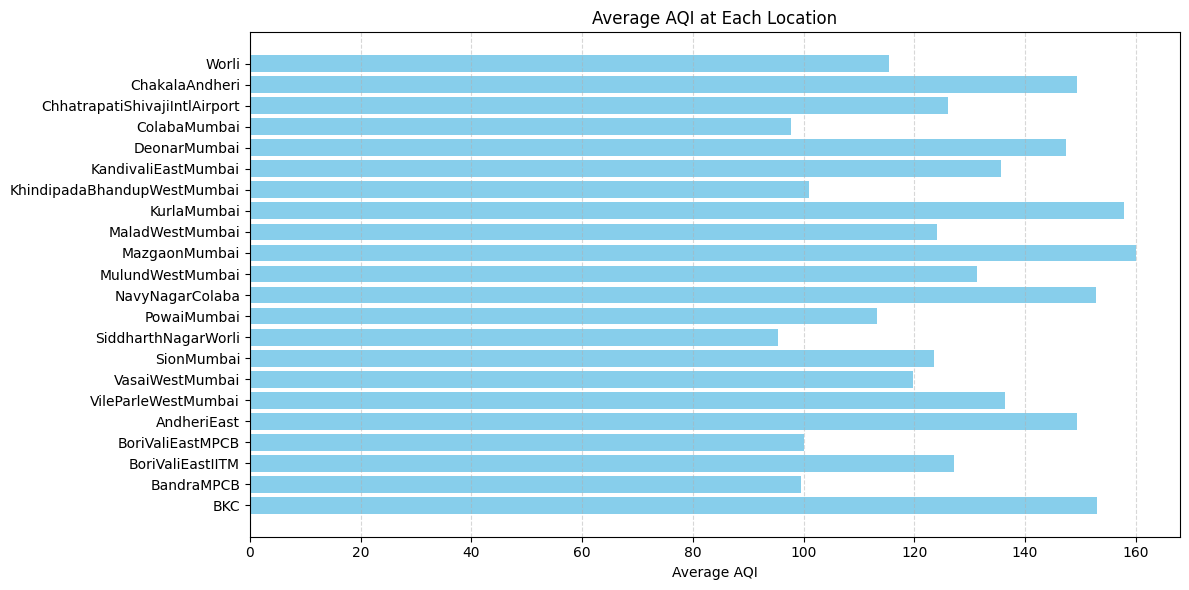

✅ Bar graph saved as 'average_aqi_bargraph.png'

📈 Generating interactive graphs for predictions...
✅ Saved interactive plot: interactive_aqi_plot_BKC.html
✅ Saved interactive plot: interactive_aqi_plot_BandraMPCB.html
✅ Saved interactive plot: interactive_aqi_plot_BoriValiEastIITM.html
✅ Saved interactive plot: interactive_aqi_plot_BoriValiEastMPCB.html
✅ Saved interactive plot: interactive_aqi_plot_AndheriEast.html
✅ Saved interactive plot: interactive_aqi_plot_VileParleWestMumbai.html
✅ Saved interactive plot: interactive_aqi_plot_VasaiWestMumbai.html
✅ Saved interactive plot: interactive_aqi_plot_SionMumbai.html
✅ Saved interactive plot: interactive_aqi_plot_SiddharthNagarWorli.html
✅ Saved interactive plot: interactive_aqi_plot_PowaiMumbai.html
✅ Saved interactive plot: interactive_aqi_plot_NavyNagarColaba.html
✅ Saved interactive plot: interactive_aqi_plot_MulundWestMumbai.html
✅ Saved interactive plot: interactive_aqi_plot_MazgaonMumbai.html
✅ Saved interactive plot: interactive

In [63]:
# === Run Script ===
if __name__ == "__main__":
    main()


#Forecast Plots


In [64]:
def plot_forecast_interactive(forecast, location):
    dates = [d for d, _ in forecast]
    values = [v for _, v in forecast]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dates, y=values, mode='lines+markers', name='Forecasted AQI'))
    fig.update_layout(title=f"7-Day AQI Forecast - {location}",
                      xaxis_title="Date", yaxis_title="AQI",
                      template="plotly_white")
    fig.write_html(f"forecast_plot_{location}.html")
    print(f"✅ Forecast plot saved: forecast_plot_{location}.html")

In [66]:
for location, file in files.items():
        if not os.path.exists(file):
            print(f"❌ Missing: {file}")
            continue
        df = load_and_clean_data(file)
        df = add_features(df)
        model, y_test, preds = train_aqi_model(df,0)
        forecast = forecast_next_7_days(df, model)
        print(f"\n🔮 {location} Forecast:")
        for date, aqi in forecast:
            print(f"{date}: AQI {aqi}")
        plot_forecast_interactive(forecast, location)


📈 AQI Model Accuracy:
  MAE : 12.59
  RMSE: 23.10
  R²  : 0.95

🔮 BKC Forecast:
2023-12-03: AQI 358.6000061035156
2023-12-04: AQI 360.32000732421875
2023-12-05: AQI 357.6199951171875
2023-12-06: AQI 353.2699890136719
2023-12-07: AQI 353.489990234375
2023-12-08: AQI 353.489990234375
2023-12-09: AQI 353.489990234375
✅ Forecast plot saved: forecast_plot_BKC.html

📈 AQI Model Accuracy:
  MAE : 3.37
  RMSE: 8.92
  R²  : 0.96

🔮 BandraMPCB Forecast:
2021-12-10: AQI 103.16000366210938
2021-12-11: AQI 103.2300033569336
2021-12-12: AQI 103.94999694824219
2021-12-13: AQI 103.97000122070312
2021-12-14: AQI 103.94999694824219
2021-12-15: AQI 103.94999694824219
2021-12-16: AQI 103.94999694824219
✅ Forecast plot saved: forecast_plot_BandraMPCB.html

📈 AQI Model Accuracy:
  MAE : 4.41
  RMSE: 10.45
  R²  : 0.98

🔮 BoriValiEastIITM Forecast:
2023-12-03: AQI 128.8300018310547
2023-12-04: AQI 125.5199966430664
2023-12-05: AQI 125.9000015258789
2023-12-06: AQI 125.79000091552734
2023-12-07: AQI 125.9000

#Route Recommendation


In [31]:
!pip install openrouteservice

In [67]:
import openrouteservice
from openrouteservice import convert
from geopy.distance import geodesic

# 🔑 Replace with your real OpenRouteService API key
ORS_API_KEY = "5b3ce3597851110001cf6248c7de9e65bb2c4c15941aa7198568b6ec"
ors_client = openrouteservice.Client(key=ORS_API_KEY)

def suggest_cleanest_nearby_location(user_lat, user_lon, trained_models, original_dfs):
    # Step 1: Calculate distances to all monitoring stations
    distances = []
    for loc, coords in LOCATION_COORDINATES.items():
        dist = geodesic((user_lat, user_lon), coords).km
        distances.append((loc, coords, dist))

    # Step 2: Find 3 nearest stations
    nearest_three = sorted(distances, key=lambda x: x[2])[:3]
    print("\n📍 Nearest 3 AQI Monitoring Locations:")
    for loc, coords, dist in nearest_three:
        print(f"  {loc}: {dist:.2f} km")

    # Step 3: Predict next day's AQI for each
    next_day_preds = []
    for loc, coords, _ in nearest_three:
        model = trained_models.get(loc)
        df = original_dfs.get(loc)
        if model and df is not None:
            forecast = forecast_next_7_days(df, model)
            if forecast:
                next_day_preds.append((loc, coords, forecast[0][1]))  # Use day 1 forecast

    # Step 4: Recommend location with lowest AQI
    if not next_day_preds:
        print("❌ No predictions available.")
        return

    recommended = min(next_day_preds, key=lambda x: x[2])
    rec_loc, rec_coords, rec_aqi = recommended
    print(f"\n✅ Recommended Location: {rec_loc} with AQI {rec_aqi}")

    # Step 5: Plot all 3 routes
    print("🗺️ Drawing All Routes on Map...")
    route_map = folium.Map(location=[user_lat, user_lon], zoom_start=12)

    # User Marker
    folium.Marker(
        [user_lat, user_lon],
        tooltip="You",
        icon=folium.Icon(color='blue')
    ).add_to(route_map)

    for loc, coords, aqi in next_day_preds:
        color = 'blue' if loc == rec_loc else 'black'
        coords_ors = ((user_lon, user_lat), (coords[1], coords[0]))  # ORS: (lon, lat)
        try:
            route = ors_client.directions(coords_ors)
            geometry = route['routes'][0]['geometry']
            decoded = convert.decode_polyline(geometry)

            # Route line
            folium.PolyLine(
                locations=[(pt[1], pt[0]) for pt in decoded['coordinates']],
                color=color,
                weight=5,
                opacity=0.8,
                tooltip=f"{loc} (AQI: {aqi})"
            ).add_to(route_map)

            # Destination marker
            folium.Marker(
                [coords[0], coords[1]],
                tooltip=f"{loc} (AQI: {aqi})",
                icon=folium.Icon(color='green' if loc == rec_loc else 'orange')
            ).add_to(route_map)

        except Exception as e:
            print(f"❌ Failed to draw route to {loc}: {e}")

    route_map.save("recommended_all_routes_map.html")
    print("✅ Route map saved as 'recommended_all_routes_map.html'")


In [68]:
trained_models = {}
original_dfs = {}

for location, path in files.items():
    flag = 1
    if not os.path.exists(path):
        continue
    df = load_and_clean_data(path)
    df = add_features(df)
    model, _, _ = train_aqi_model(df, flag)
    trained_models[location] = model
    original_dfs[location] = df


In [48]:
user_lat = float(input("📍 Enter your current Latitude: "))
user_lon = float(input("📍 Enter your current Longitude: "))
suggest_cleanest_nearby_location(user_lat, user_lon, trained_models, original_dfs)


📍 Enter your current Latitude: 18.9720
📍 Enter your current Longitude: 73.0348

📍 Nearest 3 AQI Monitoring Locations:
  DeonarMumbai: 15.38 km
  KurlaMumbai: 19.35 km
  BandraMPCB: 19.45 km

✅ Recommended Location: BandraMPCB with AQI 103.16000366210938
🗺️ Drawing All Routes on Map...
✅ Route map saved as 'recommended_all_routes_map.html'
